### Coding GPT architecture


In [4]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim":768 , # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

In [5]:
import torch 
import torch.nn as nn 


class MultiHeadAttention(nn.Module):
    def __init__(self , d_in , d_out , context_length , dropout , num_heads , qkv_bias = False):
        super().__init__()
        assert (d_out % num_heads == 0) ,  "d_out must be divisble by num_heads"
        
        self.d_out = d_out 
        self.num_heads = num_heads 
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in , d_out , bias = qkv_bias)
        self.W_key = nn.Linear(d_in , d_out , bias = qkv_bias)
        self.W_value = nn.Linear(d_in , d_out , bias = qkv_bias)
        self.out_proj = nn.Linear(d_out , d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length,context_length), diagonal=1)
        )
        
        
    
    def forward(self, x ): 
        b , num_tokens , d_in = x.shape # x.shape = (2,6,3)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        # splitting the key query and value vectors to feed into multiple heads 
        
        keys = keys.view(b,num_tokens ,self.num_heads , self.head_dim) # reshaping using view function
        queries = queries.view(b,num_tokens ,self.num_heads , self.head_dim) 
        values = values.view(b,num_tokens ,self.num_heads , self.head_dim) 
        
        # transposing the dimensions 
        
        keys = keys.transpose(1,2)  #(b , self.num_heads , num_tokens , self.head_dim)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)
        
        attn_scores = queries @ keys.transpose(2,3) #(b , self.num_heads ,self_head_dim , num_tokens) 
        
        # causal masking 
        mask_bool = self.mask.bool()[:num_tokens , :num_tokens]
        
        attn_scores.masked_fill_(mask_bool , -torch.inf)
        
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5 , dim = -1
        )
        attn_weights = self.dropout(attn_weights)
        
        # calculate the context vector 
        context_vec = (attn_weights @ values).transpose(1,2)  # Tensor shape:(b, num_tokens,n_heads,head_dim)
        
        # combining heads into a single vector 
        context_vec = context_vec.contiguous().view(b,num_tokens,self.d_out)
        
        # adding the optional linear projection to transform the output into right dimension
        context_vec = self.out_proj(context_vec)
        return context_vec
        
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self , x ):
        mean = x.mean(dim = -1 , keepdim = True)
        var = x.var(dim = -1 , keepdim = True , unbiased= False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift 
    

class GELU(nn.Module): 
    def __init__(self):
        super().__init__()
    
    def forward(self , x ):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x , 3))
        ))
        


class FeedForward(nn.Module) : 
    def __init__(self, cfg ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'] , 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'] , cfg['emb_dim']),    )
        
    def forward(self, x ): 
        return self.layers(x)
    
    

class TransformerBlock(nn.Module):
    def __init__(self,  cfg):
        super().__init__()
        self.attn  = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length= cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg=cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])
            
    def forward(self,x):
        shortcut = x 
        x = self.norm1(x) 
        x = self.attn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.norm2(x)
        x = self. ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x 
             

class GPTModel(nn.Module):
    def __init__(self , cfg): 
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg["context_length"] , cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg)
              for _ in range (cfg['n_layers'])]
        )
        
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg["emb_dim"] , cfg["vocab_size"] , bias = False
        )
        
    def forward(self , in_idx):
        batch_size , seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len , device = in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits 
    


In [6]:
# let's test the dummy transformer by send the processing the sample data 

import tiktoken
 
tokenizer = tiktoken.get_encoding('gpt2')
batch = [] 

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim = 0 )
print(batch )

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [8]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [9]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [10]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [11]:
## Let's  convert the prediction back to text 

def generate_text_simple(model , idx , max_new_token , context_size):
    for _ in range(max_new_token):
        idx_cond  = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:,-1 ,:]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas , dim= -1 , keepdim=True)
        idx = torch.cat((idx , idx_next),dim=1)

    return idx     

In [12]:
start_context = "Hello , I am"
encoded = tokenizer.encode(start_context)
print(encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(encoded_tensor.shape)

[15496, 837, 314, 716]
torch.Size([1, 4])


In [13]:
# let's generate the text 

model.eval() # disable the dropout layer for inference 
out = generate_text_simple(
    model=model , 
    idx = encoded_tensor , 
    max_new_token=6, 
    context_size= GPT_CONFIG_124M["context_length"]
)
print(out)
print("output length:",len(out[0]))

tensor([[15496,   837,   314,   716, 27018,  7283, 48443, 26012, 16560, 44407]])
output length: 10


In [14]:
decode_text = tokenizer.decode(out.squeeze(0).tolist())
print(decode_text)

Hello , I am Feature IT!/ Brigade incorporatedheartedly


In [15]:
GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256,
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12,
 "drop_rate": 0.1,
 "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featur

In [16]:
# Utility functions for text to token and token to text conversion

def text_to_token_ids(text , tokenizer):
    encoded = tokenizer.encode(text , allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids , tokenizer):
    decoded_text = tokenizer.decode(token_ids.squeeze(0).tolist())
    return decoded_text

In [17]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model , 
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_token=10,
    context_size=GPT_CONFIG_124M['context_length']
    
)
print(token_ids)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])
Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [18]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
 [40, 1107, 588]]) # "I really like"]

targets = torch.tensor([[3626, 6100, 354 ], # [" effort moves you",
 [1107, 588, 11311]]) # " really like chocolate"]

In [19]:
with torch.no_grad():
 logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [20]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [21]:
print(f"Targets batch 1: {token_ids_to_text(targets.flatten(), tokenizer)}")
print(f"Outputs batch 1:"f" {token_ids_to_text(token_ids.flatten(), tokenizer)}")

Targets batch 1:  effort movesch really like chocolate
Outputs batch 1:  Armed heNetflix pressuring empoweredfaith


In [22]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 3.7604e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [23]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -10.1884, -11.4798,  -9.7764, -12.2561])


In [24]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(-10.5974)
tensor(10.5974)


In [25]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [26]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [27]:
import torch.nn.functional


loss = torch.nn.functional.cross_entropy(logits_flat , targets_flat)
print(loss)

tensor(10.5974)


In [28]:
# perplexity 

perplexity = torch.exp(loss)
print(perplexity)

tensor(40031.1445)


In [29]:
file_path = "the-verdict.txt"
with open(file_path, 'r' , encoding="utf-8") as file : 
    text_data = file.read()

In [30]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(total_characters)
print(total_tokens)

20479
5145


In [31]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [32]:
from data_prep import create_dataloader_v1

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)


torch.Size([8, 4, 256])


In [33]:
print("Train loader:")
for x, y in train_loader:
 print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
 print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [34]:
def calc_loss_batch(input_batch , target_batch , model , device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
    return loss

In [35]:
# loss calcuation over the entire batch 

def calc_loss_loader(data_loader , model , device , num_batches = None):
    total_loss = 0 
    if len(data_loader)  == 0 :
        return float("nan")
    elif num_batches is None: 
        num_batches = len(data_loader)
        print("Length of dataloader:",len(data_loader))
    else:
        num_batches = min(num_batches , len(data_loader))
    for i , (input_batch , target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch , target_batch , model , device
            )
            total_loss +=loss.item()
        else: 
            break
    return total_loss / num_batches

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader , model , device)
    val_loss = calc_loss_loader(val_loader , model , device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Length of dataloader: 9
Length of dataloader: 1
Training loss: 10.987583584255642
Validation loss: 10.981106758117676


In [37]:
def evaluate_model (model , train_loader , val_loader , device , eval_iter) : 
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader , model , device , num_batches= eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader , model , device , num_batches=eval_iter
        )
    model.train()
    return train_loss , val_loss

In [38]:
def generate_and_print_sample(model , tokenizer , device , start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context , tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model = model , idx = encoded ,
            max_new_token=50 , context_size = context_size
        )
    decoded_text = token_ids_to_text(token_ids , tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [39]:
# training the llm to reduce the loss 
def train_model_simple(model , train_loader , val_loader , optimizer, device , num_epochs,
                       eval_freq , eval_iter , start_context , tokenizer):
    train_losses , val_losses , track_token_seen = [] , [] ,[] 
    token_seen , global_step = 0 ,-1 
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch ,target_batch in train_loader : 
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch , target_batch ,model , device
            )
            loss.backward()
            optimizer.step()
            token_seen += input_batch.numel()
            global_step += 1 

            if global_step & eval_freq  == 0 : 
                train_loss, val_loss = evaluate_model(
                    model , train_loader , val_loader , device , eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seen.append(token_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                    )
        
        generate_and_print_sample(
            model , tokenizer , device , start_context
        )     
        
    return train_losses , val_losses , track_token_seen      

In [40]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
 model.parameters(),
 lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
 model, train_loader, val_loader, optimizer, device,
 num_epochs=num_epochs, eval_freq=5, eval_iter=5,
 start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000002): Train loss 8.955, Val loss 9.133
Ep 1 (Step 000008): Train loss 7.194, Val loss 7.473
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.598, Val loss 7.052
Ep 2 (Step 000016): Train loss 5.973, Val loss 6.561
Every effort moves you, and, and, and, and, and, and, and, and,, and,,,,, and, and, and,, and, and,, and, and,, and, and,, and,, and
Ep 3 (Step 000018): Train loss 5.972, Val loss 6.517
Ep 3 (Step 000024): Train loss 5.562, Val loss 6.448
Ep 3 (Step 000026): Train loss 5.138, Val loss 6.375
Every effort moves you. "I to the to the the to the to the the. I had the--I was--I to the to the to the the to the the the to the the to the to the the to the to the to the to the
Ep 4 (Step 000032): Train loss 4.377, Val loss 6.448
Ep 4 (Step 000034): Train loss 4.325, Val loss 6.255
Every effort moves you know it, and he had been--and it, and I had been the.       

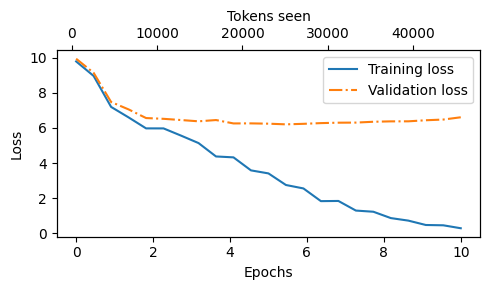

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
 fig, ax1 = plt.subplots(figsize=(5, 3))
 ax1.plot(epochs_seen, train_losses, label="Training loss")
 ax1.plot(
 epochs_seen, val_losses, linestyle="-.", label="Validation loss"
 )
 ax1.set_xlabel("Epochs")
 ax1.set_ylabel("Loss")
 ax1.legend(loc="upper right")
 ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
 ax2 = ax1.twiny()
 ax2.plot(tokens_seen, train_losses, alpha=0)
 ax2.set_xlabel("Tokens seen")
 fig.tight_layout()
 plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


In [42]:
model.to('cpu')
model.eval()

tokenizer = tiktoken.get_encoding('gpt2')
token_ids = generate_text_simple(
    model = model, 
    idx = text_to_token_ids("Every effort moves you" , tokenizer),
    max_new_token = 25 ,
    context_size= GPT_CONFIG_124M['context_length']
)
print("Output text :\n" , token_ids_to_text(token_ids , tokenizer))


Output text :
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [ ]:
# Let's modify the generate_text_simple by combining the temperature sampling and top-k sampling 


def generate(model, idx , max_new_tokens , context_size ,
             temperature=0.0 , top_k =None , eos_id = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]
        
        if top_k is not None: 
            top_logits , _ = torch.topk(logits , top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                logits < min_val , 
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature 
            probas = torch.softmax(logits , dim = -1)
            idx_next = torch.multinomial(probas , num_samples=1)
        else: 
            idx_next = torch.argmax(logits , dim = -1 ,keepdim = True)
        
        if idx_next == eos_id : 
            break 
            
        idx = torch.cat((idx , idx_next ),dim = 1)
    return idx 

In [61]:
torch.manual_seed(123)
token_ids = generate(
    model = model , 
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens= 20 , 
    context_size=GPT_CONFIG_124M['context_length'],
    top_k = 5 ,
    temperature = 0.5
    
) 
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and


In [59]:
torch.save(model.state_dict(),"model_pth")


In [60]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model_pth",map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featur

In [62]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [63]:
checkpoint = torch.load("model_and_optimizer.pth",map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4 , weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featur

In [64]:
import urllib.request
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x185d7411840>)

In [82]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
 model_size="355M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 25.7kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 482kiB/s] 
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 45.5kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [07:02<00:00, 3.36MiB/s]  
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 5.27MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 608kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 397kiB/s]  


In [83]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())


Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1024, 'n_head': 16, 'n_layer': 24}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [84]:
print(params)

{'blocks': [{'attn': {'c_attn': {'b': array([ 6.5407079e-01, -6.4520276e-01,  1.5412229e-01, ...,
        3.9472539e-04, -1.1913106e-03, -2.0954411e-03], dtype=float32), 'w': array([[ 0.07517347,  0.03569016, -0.0045204 , ..., -0.04698672,
         0.01586862, -0.05079569],
       [-0.20343858, -0.23416115, -0.12388402, ..., -0.10114633,
         0.02333787, -0.00287042],
       [-0.04787058, -0.20874114, -0.08843362, ...,  0.02041811,
        -0.01904844,  0.01036439],
       ...,
       [ 0.01329984, -0.03209405, -0.20156056, ..., -0.02571667,
        -0.05338867,  0.03378934],
       [-0.43131468,  0.06190351, -0.34512466, ..., -0.03697858,
         0.00522314, -0.00135449],
       [ 0.4025124 ,  0.1701651 ,  0.2707895 , ..., -0.01399677,
        -0.01223649,  0.05628034]], dtype=float32)}, 'c_proj': {'b': array([-0.00091882, -0.03253085, -0.02656874, ...,  0.0021506 ,
        0.01144931, -0.0086791 ], dtype=float32), 'w': array([[ 0.09731582,  0.00315875,  0.03116801, ...,  0.06896

In [85]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.0115168   0.00311915 -0.00729894 ... -0.05262156 -0.17569277
   0.02565791]
 [-0.00861426  0.06360211 -0.01822355 ... -0.01364703 -0.12153847
   0.05352487]
 [ 0.05854857  0.06891199  0.02622696 ... -0.10057542 -0.19788682
  -0.0039184 ]
 ...
 [ 0.00162342 -0.04411932 -0.0517492  ... -0.10079621 -0.00865952
   0.02637872]
 [-0.14374605 -0.04632217 -0.00650705 ...  0.07464293 -0.04721651
  -0.03829013]
 [ 0.02065966 -0.01334631 -0.02586888 ...  0.03886637 -0.00233481
   0.00107106]]
Token embedding weight tensor dimensions: (50257, 1024)


In [89]:
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-medium (355M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [90]:
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

In [91]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear

In [92]:
def assign(left, right):
 if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, "
    "Right: {right.shape}"
    )
 return torch.nn.Parameter(torch.tensor(right))

In [93]:
# loading the openai weights in the our gpt architecture

import numpy as np
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.weight = assign(
        gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.W_key.weight = assign(
        gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.W_value.weight = assign(
        gpt.trf_blocks[b].attn.W_value.weight, v_w.T)
        q_b, k_b, v_b = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.bias = assign(
        gpt.trf_blocks[b].attn.W_query.bias, q_b)
        gpt.trf_blocks[b].attn.W_key.bias = assign(
        gpt.trf_blocks[b].attn.W_key.bias, k_b)
        gpt.trf_blocks[b].attn.W_value.bias = assign(
        gpt.trf_blocks[b].attn.W_value.bias, v_b)
        gpt.trf_blocks[b].attn.out_proj.weight = assign(
        gpt.trf_blocks[b].attn.out_proj.weight,
        params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attn.out_proj.bias = assign(
        gpt.trf_blocks[b].attn.out_proj.bias,
        params["blocks"][b]["attn"]["c_proj"]["b"])
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
        gpt.trf_blocks[b].ff.layers[0].weight,
        params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
        gpt.trf_blocks[b].ff.layers[0].bias,
        params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
        gpt.trf_blocks[b].ff.layers[2].weight,
        params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
        gpt.trf_blocks[b].ff.layers[2].bias,
        params["blocks"][b]["mlp"]["c_proj"]["b"])
        gpt.trf_blocks[b].norm1.scale = assign(
        gpt.trf_blocks[b].norm1.scale,
        params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
        gpt.trf_blocks[b].norm1.shift,
        params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
        gpt.trf_blocks[b].norm2.scale,
        params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
        gpt.trf_blocks[b].norm2.shift,
        params["blocks"][b]["ln_2"]["b"])
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [94]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear

In [95]:
torch.manual_seed(123)
token_ids = generate(
 model=gpt,
 idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
 max_new_tokens=25,
 context_size=NEW_CONFIG["context_length"],
 top_k=50,
 temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward balance." But it seems quite different at any speed or type of energy.

If you're trying to get energy


In [96]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader , model , device)
    val_loss = calc_loss_loader(val_loader , model , device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Length of dataloader: 9
Length of dataloader: 1
Training loss: 0.39402374625205994
Validation loss: 6.527970790863037
